## 1. Modules

In [1]:
# import basic modules
import pandas as pd
import warnings
import numpy as np
import os
import glob

In [2]:
# import all modules related to visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import q_stat, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [4]:
# filter warnings
warnings.filterwarnings("ignore")

## 2. Import Data

In [5]:
# read in all the csv-files
path = os.getcwd() + "/Model Data/Multivariate"
files = glob.glob(os.path.join(path, "*.csv"))
file_list = list()
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

In [6]:
# set the date as index
for i in range(len(file_list)):
    file_list[i]["DATE"] = pd.to_datetime(file_list[i]["DATE"])
    file_list[i].set_index("DATE", inplace = True)

In [7]:
training, testing = [f for f in file_list]

## 3. Model Training (in-sample)

In [8]:
# in-sample forecast evaluation for var models:
# 1. fit model parameters on the training sample and compute the aicc
# 2. produce one-step-ahead forecasts for each value in the training sample
# 3. expand the sample to include the next observation, and repeat
# 4. compare fitted values against training sample
def evaluate_model(training, order):
    # fit model on training sample
    model = VAR(training)
    model_fit = model.fit(order)
    y_hat = model_fit.fittedvalues
    # save original data and fitted values
    model_data = pd.DataFrame(training["GDP"].copy())
    model_data["fitted_values"] = y_hat["GDP"]
    model_data = model_data.dropna()
    # compute the rmse for the given order of p
    rmse = np.sqrt(mean_squared_error(model_data.iloc[:,0], model_data.iloc[:,1]))
    # return the rmse, fitted values, aicc score and residuals
    return model_fit.aic, rmse, model_data, model_fit.resid["GDP"]

$$ \begin{aligned}
\text{VAR(p) } : \;\; X_{t} &= c + \Lambda_{1}X_{t-1} + \Lambda_{2}X_{t-2} + \cdots + \Lambda_{p}X_{t-p} + \epsilon_{t} \;\; \text{with} \;\; \epsilon_{t} \sim \mathcal{N}(0,\Sigma) \\ 
&= c + \sum^{p}_{i=1} \Lambda_{i}X_{t-i} + \epsilon_{t}
\end{aligned} $$

### 3.1 Grid-Search

In [9]:
# grid-search for finding the best lag order p for var model
def grid_search(training, p_grid):
    best_score, best_cfg = float("inf"), None
    aic_values = list()
    for p in p_grid:
        try:
            aic, rmse, model_data, residuals = evaluate_model(training, p)
            if aic < best_score:
                best_score, best_rmse, best_cfg, best_model_data, best_resid = aic, rmse, p, model_data, residuals
            print("> VAR(%s); AIC = %.2f" % (p, aic))
            aic_values.append(aic)
        except:
            continue
    # print best model and return best configuration and best scores 
    print("> best model: VAR(%s) with AIC of %.2f" % (best_cfg, best_score))
    return best_cfg, best_model_data, aic_values, best_rmse, best_resid

In [10]:
# select range of parameters
p = range(0,16)

In [11]:
# run the grid-search
best_cfg, model_data, aic_values, rmse, residuals = grid_search(training, p)

> VAR(0); AIC = 3.99
> VAR(1); AIC = 3.11
> VAR(2); AIC = 2.95
> VAR(3); AIC = 2.91
> VAR(4); AIC = 2.88
> VAR(5); AIC = 2.69
> VAR(6); AIC = 2.68
> VAR(7); AIC = 2.64
> VAR(8); AIC = 2.64
> VAR(9); AIC = 2.61
> VAR(10); AIC = 2.55
> VAR(11); AIC = 2.46
> VAR(12); AIC = 2.42
> VAR(13); AIC = 2.47
> VAR(14); AIC = 2.49
> VAR(15); AIC = 2.48
> best model: VAR(12) with AIC of 2.42


### 3.2 Model Visualization

In [12]:
# visualization of model training and the corresponding aic
def plot_model(model_data, aic, rmse):
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1], width_ratios = [3, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # plot actual and fitted values
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Actual")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted", linestyle = "-")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP Growth")
    ax1.set_title("Fitted Values for best ARIMA Combination (RMSE = %.3f)" % (rmse), loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)

    ax2 = plt.subplot(gs[0, 1])
    # plot aicc values
    ax2.plot(aic, color = "green")
    ax2.set_xlabel("Grid-Search Iteration")
    ax2.set_ylabel("AIC Value")
    ax2.set_title("Corresponding AIC", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values (yearly average)
    ax3.plot(model_data.iloc[:,0].resample("Y").mean(), color = "darkblue", 
             label = "Actual")
    ax3.plot(model_data.iloc[:,1].resample("Y").mean(), color = "red", 
             label = "Fitted", linestyle = "-")
    ax3.set_title("Fitted Values (Yearly Average)", loc = "left")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Real GDP Growth")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax3.legend(frameon = False)
    
    # layout optimization
    plt.tight_layout()

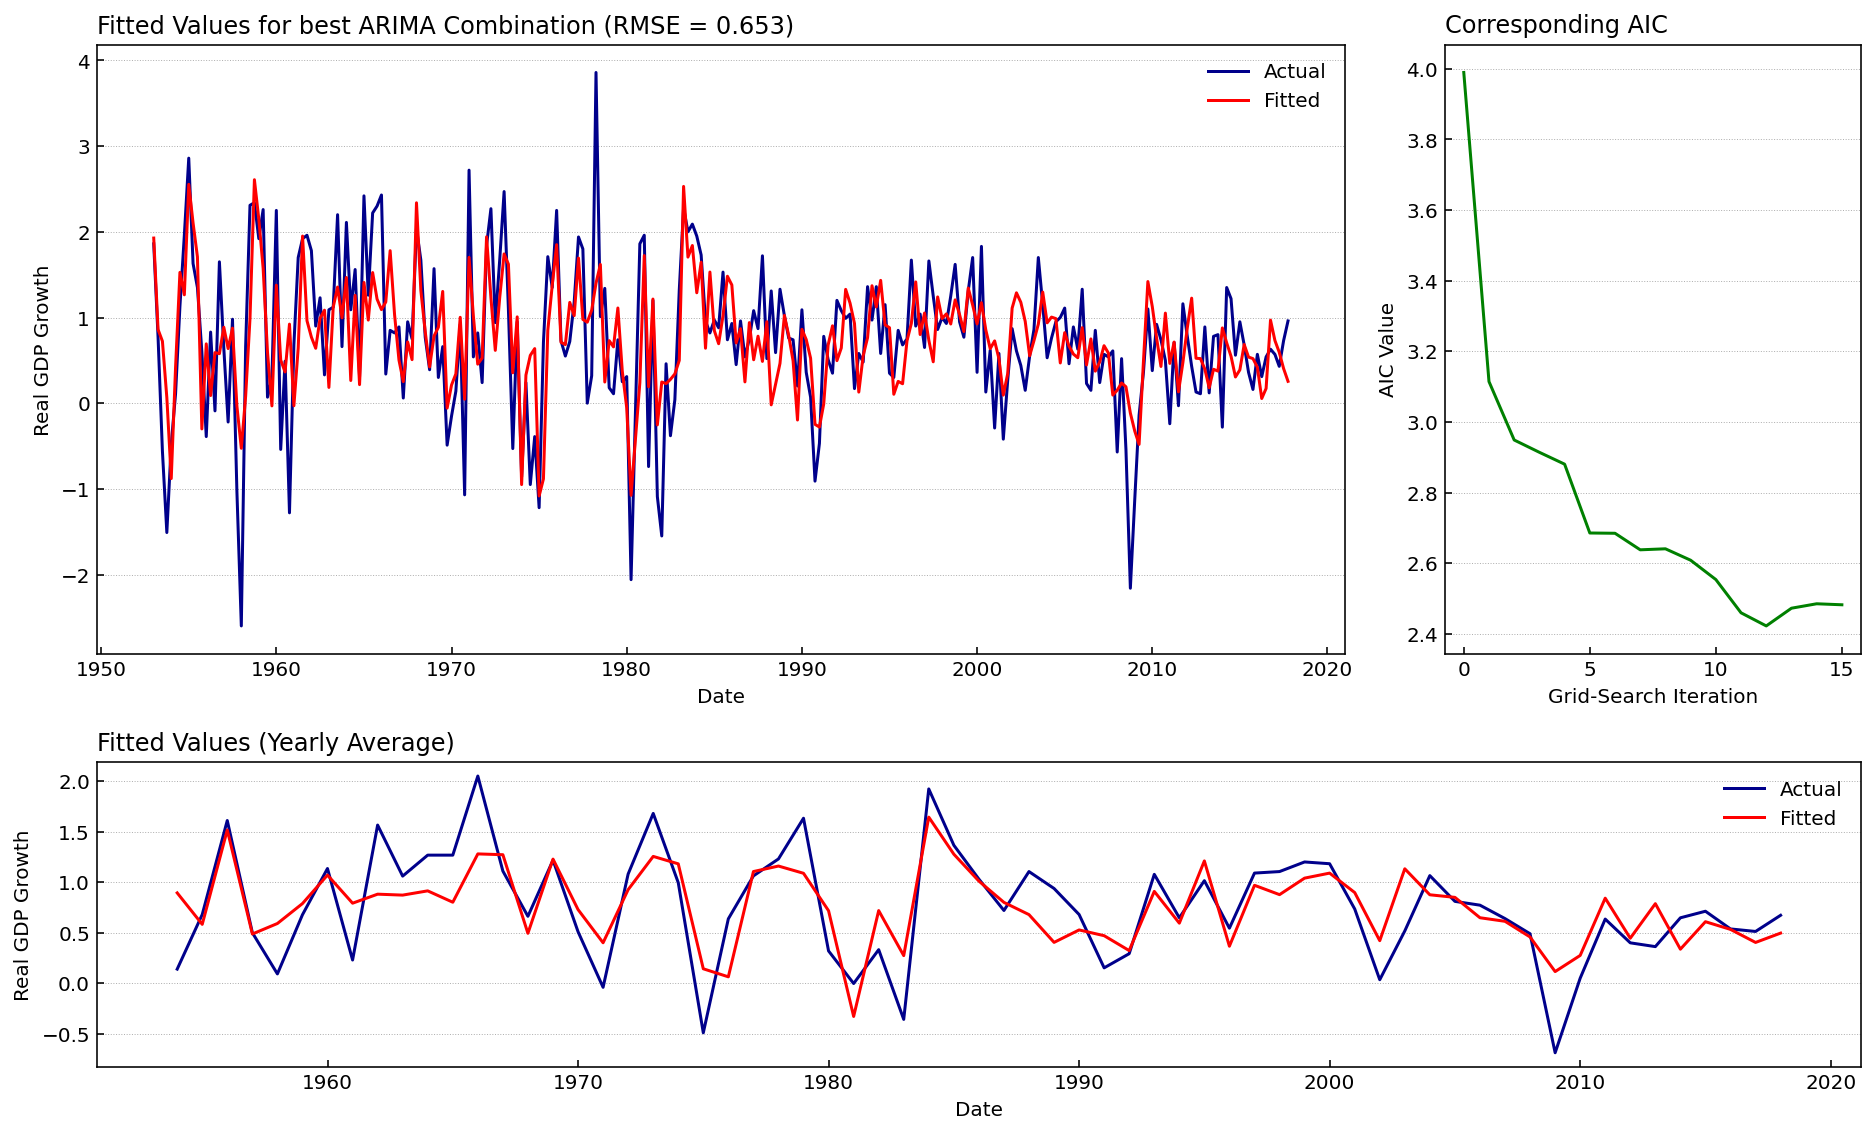

In [13]:
# visualize the model training
plot_model(model_data, aic_values, rmse)

## 4. Residual Diagnostics

In [14]:
# good forecasting methods will yield residuals with the following properties:
# 1. The residuals are uncorrelated (otherwise there is information left)
# 2. The residuals have zero mean (otherwise the forecasts are biased)
# 3. The residuals have constant variance (useful, but not necessary)
# 4. The residuals are normally distributed (useful, but not necessary)
def plot_residuals(data):   
    gs = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
    plt.figure(figsize = (13,8))

    ax1 = plt.subplot(gs[0, 0])
    # distribution plot
    residuals.plot(kind = "density", ax = ax1, color = "darkblue", legend = False)
    ax1.set_title("Density of Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # normal distribution
    mean, std = stats.norm.fit(residuals)
    x = np.linspace(-8, 8, 300)
    p = stats.norm.pdf(x, mean, std)
    ax1.plot(x, p, "green")
    ax1.legend(["Residuals", "Normal"], frameon = False)
    ax1.axvline(x = 0, color = "red", linestyle = "--")

    ax2 = plt.subplot(gs[0, 1])
    # compute the autocorrelation coefficients of the residuals and plot them
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(residuals)), color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_ylim(-0.25, 0.25)
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

    ax3 = plt.subplot(gs[1, :])
    # plot actual and fitted values on yearly average
    ax3.plot(residuals, color = "darkblue")
    ax3.axhline(y = 0, color = "red", linestyle = "--")
    ax3.set_title("Residuals", loc = "left")
    ax3.set_xlabel("Date")
    ax3.tick_params(direction = "in")
    ax3.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

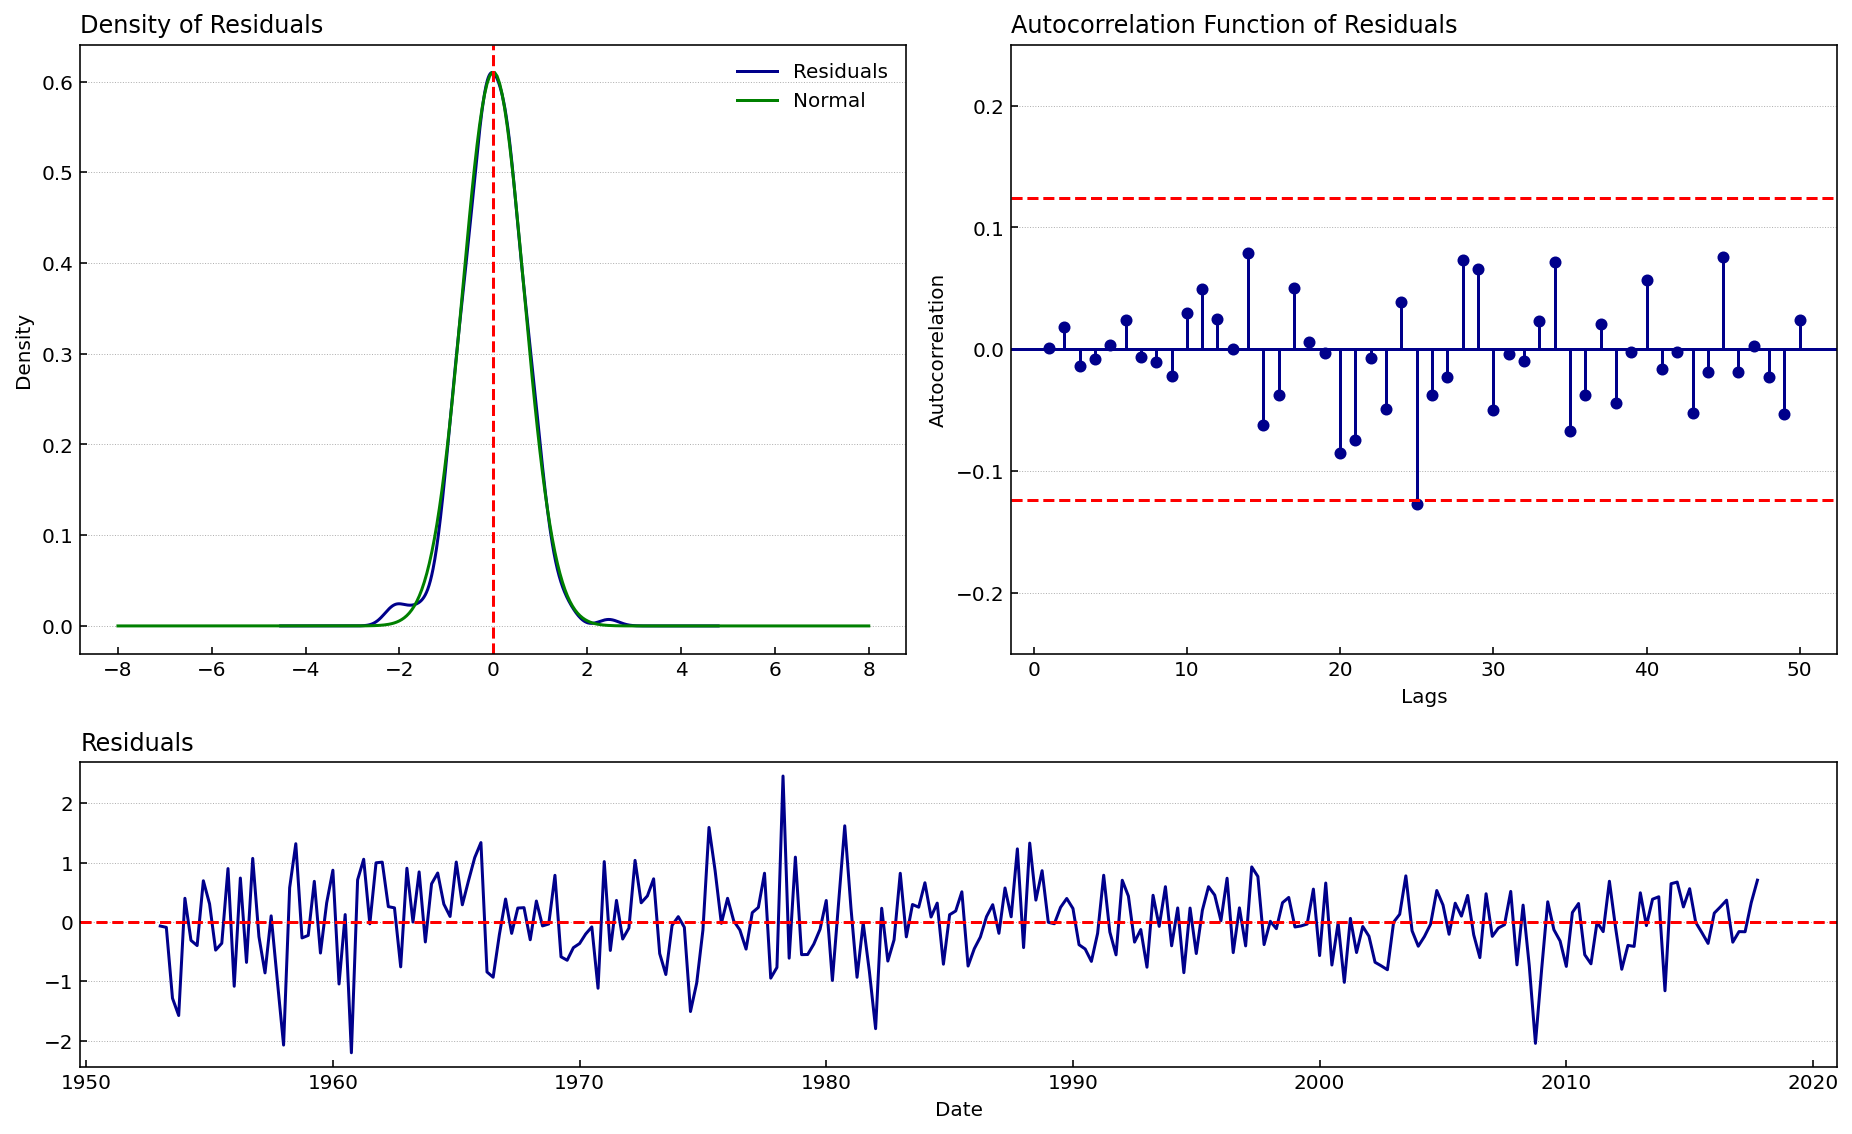

In [15]:
# residuals for chosen parameter combination on full training data
plot_residuals(residuals)

### 4.1 Goldfeld-Quandt Test for Heteroskedasticity

In [16]:
# source code from statsmodels for Goldfeld-Quandt test
def heteroskedasticity_test(resid):
    squared_resid = np.asarray(resid, dtype = float) ** 2
    if squared_resid.ndim == 1:
        squared_resid = squared_resid.reshape(-1, 1)
    nobs = len(resid)

    h = int(np.round(nobs * 1/3))

    numer_resid = squared_resid[-h:]
    numer_dof = (~np.isnan(numer_resid)).sum(axis = 0)
    numer_squared_sum = np.nansum(numer_resid, axis = 0)

    denom_resid = squared_resid[:h]
    denom_dof = (~np.isnan(denom_resid)).sum(axis = 0)
    denom_squared_sum = np.nansum(denom_resid, axis = 0)

    test_statistic = numer_squared_sum / denom_squared_sum

    from scipy.stats import f
    pval_lower = lambda test_statistics: f.cdf(test_statistics, numer_dof, denom_dof)
    pval_upper = lambda test_statistics: f.sf(test_statistics, numer_dof, denom_dof)
    p_value = 2 * np.minimum(pval_lower(test_statistic), pval_upper(test_statistic))

    return test_statistic, p_value

In [17]:
# Goldfeld-Quandt test
# null hypothesis : homoscedasticity of residuals (constant variance)
# alternate hypothesis : heteroscedasticity of residuals (variance not constant)
# reject null hypothesis if p-value <= 0.05
def gq_test(data):
    gq_test = heteroskedasticity_test(data)
    test_statistic, p_value = gq_test[0], gq_test[1]
    print("> goldfeld-quandt test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))

In [18]:
gq_test(residuals)

> goldfeld-quandt test results:
> test statistic = 0.48
> p-value = 0.00


### 4.2 Ljung-Box-Q Test for Autocorrelation

In [19]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq_test = acorr_ljungbox(data)
    test_statistic, p_value = lbq_test[0].mean(), lbq_test[1].mean()
    print("> ljung-box test results:")
    print("> average test statistic = %.2f" % (test_statistic))
    print("> average p-value = %.2f" % (p_value))

In [20]:
lbq_test(residuals)

> ljung-box test results:
> average test statistic = 10.00
> average p-value = 0.98


### 4.3 Jarque-Bera Test for Normality

In [21]:
# Jarque-Bera test
# null hypothesis : data is normally distributed
# alternate hypothesis : data is not normally distributed
# reject null hypothesis if p-value <= 0.05
def jb_test(data):
    jb_test = jarque_bera(data)
    test_statistic, p_value, skew, kurtosis = jb_test[0], jb_test[1], jb_test[2], jb_test[3]
    print("> jarque-bera test results:")
    print("> test statistic = %.2f" % (test_statistic))
    print("> p-value = %.2f" % (p_value))
    print("> estimated skew = %.2f" % (skew))
    print("> estimated kurtosis = %.2f" % (kurtosis))

In [22]:
jb_test(residuals)

> jarque-bera test results:
> test statistic = 12.31
> p-value = 0.00
> estimated skew = -0.14
> estimated kurtosis = 4.03


## 5. Forecasting (out-of-sample)

In [23]:
model = VAR(training)
model_fit = model.fit(best_cfg)
forecast_input = training.values[-best_cfg:]
forecast_data = model_fit.forecast_interval(forecast_input, len(testing), alpha = 0.2)
y_hat = forecast_data[0]
ci_lower = forecast_data[1]
ci_upper = forecast_data[2]
y_hat = pd.DataFrame(y_hat, index = testing.index[-best_cfg:], columns = testing.columns)
ci_lower = pd.DataFrame(ci_lower, index = testing.index[-best_cfg:], columns = testing.columns)
ci_upper = pd.DataFrame(ci_upper, index = testing.index[-best_cfg:], columns = testing.columns)
rmse = np.sqrt(mean_squared_error(testing["GDP"], y_hat["GDP"]))
for t in range(len(y_hat.values)):
    date = str.split(str(y_hat.index[t]))[0]
    print("> (%s) forecasted = %.2f; actual = %.2f" % (date, y_hat["GDP"].values[t], testing["GDP"].values[t]))

> (2018-01-01) forecasted = 0.78; actual = 0.93
> (2018-04-01) forecasted = 0.48; actual = 0.67
> (2018-07-01) forecasted = 0.62; actual = 0.53
> (2018-10-01) forecasted = 0.48; actual = 0.33
> (2019-01-01) forecasted = 0.57; actual = 0.73
> (2019-04-01) forecasted = 0.60; actual = 0.37
> (2019-07-01) forecasted = 0.74; actual = 0.64
> (2019-10-01) forecasted = 0.51; actual = 0.59


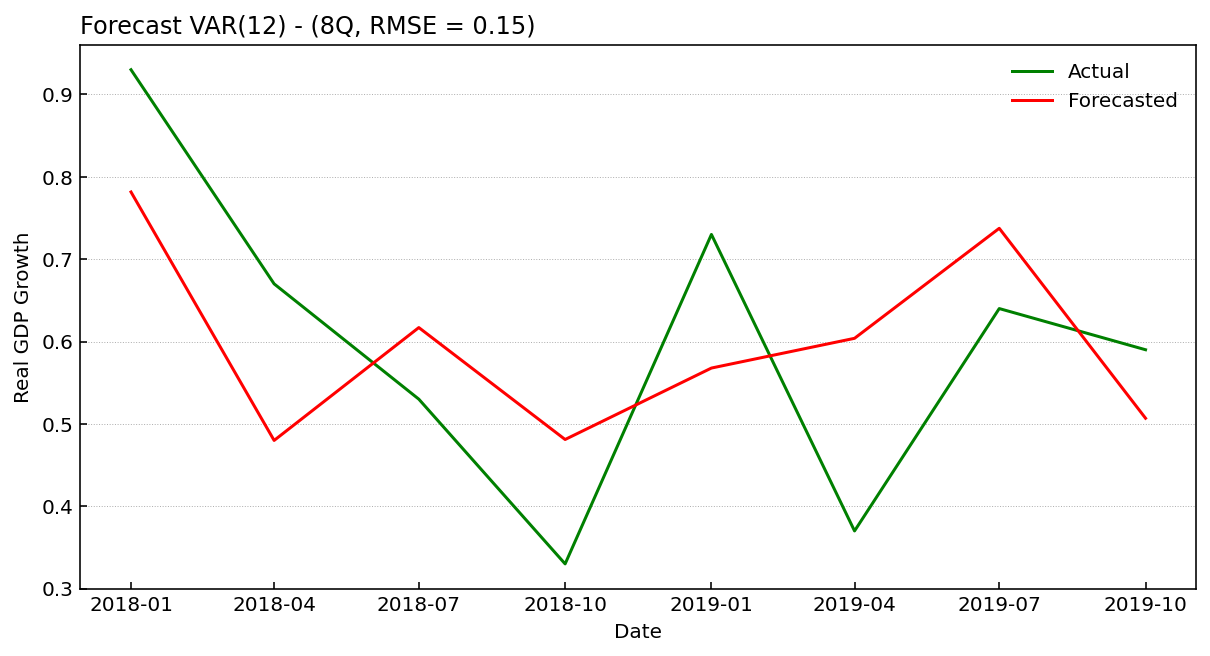

In [30]:
plt.figure(figsize = (10,5))
plt.plot(testing["GDP"], color = "green", label = "Actual")
plt.plot(y_hat["GDP"], color = "red", label = "Forecasted")
# plt.fill_between(y_hat.index, ci_lower["GDP"], ci_upper["GDP"], 
#                 color = "k", alpha = 0.1, label = r"CI ($\alpha = 0.2$)")
plt.xlabel("Date")
plt.ylabel("Real GDP Growth")
plt.title("Forecast VAR(%s) - (8Q, RMSE = %.2f)" % (best_cfg, rmse), loc = "left")
plt.tick_params(direction = "in")
plt.grid(axis = "y", linewidth = 0.5, linestyle = ":")
plt.legend(frameon = False)
plt.show()